In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
from matplotlib.colors import LogNorm, ListedColormap


import yt
from yt import YTArray, YTQuantity
import trident
import numpy as np
import sys
import h5py as h5


import seaborn as sns
import palettable
sns.set_style("ticks",{'axes.grid': True, 'grid.linestyle': '--'})

sys.path.append('../analysis')
import spectrum_generating_tools as spg
import ion_plot_definitions as ipd
import plotting_tools as pt


/Users/irynabutsky/software/yt/yt/utilities/logger.py:4: VisibleDeprecationWarning: The configuration file /Users/irynabutsky/.config/yt/ytrc is deprecated in favor of /Users/irynabutsky/.config/yt/yt.toml. Currently, both are present. Please manually remove the deprecated one to silence this warning.
Deprecated since v4.0.0 . This feature will be removed in v4.1.0
  from yt.config import ytcfg


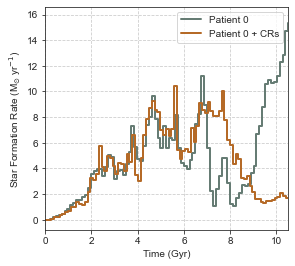

In [71]:
# star formation history plot

#load data
f = h5.File('../../data/simulation_data/sfh_data.h5', 'r')

fig, ax = plt.subplots(figsize = (4.2, 3.8))
ax.set_xlabel('Time (Gyr)')
ax.set_ylabel('Star Formation Rate (M$_{\odot}$ yr$^{-1}$)')
ax.set_xlim(0, 10.5)


color_list = palettable.wesanderson.Moonrise2_4.mpl_colors[:2]
for model, label, color in zip(['p0', 'agncr'], ['Patient 0', 'Patient 0 + CRs'], color_list):
     
    x = np.array(f['time_%s'%model])
    y = np.array(f['sfh_%s'%model])
    
    x = np.vstack((x[:-1], x[1:])).reshape((-1), order = 'F')
    y = np.vstack((y, y)).reshape((-1), order = 'F')

    ax.plot(x, y, linewidth = 2, label = label, color = color)

ax.legend()
fig.tight_layout()
plt.savefig('../../plots/sfh.png', dpi = 300)


yt : [INFO     ] 2021-02-08 17:52:06,941 Parameters: current_time              = 3.398869692888919e+17 s
yt : [INFO     ] 2021-02-08 17:52:06,942 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2021-02-08 17:52:06,942 Parameters: domain_left_edge          = [-0.5 -0.5 -0.5]
yt : [INFO     ] 2021-02-08 17:52:06,943 Parameters: domain_right_edge         = [0.5 0.5 0.5]
yt : [INFO     ] 2021-02-08 17:52:06,944 Parameters: cosmological_simulation   = 1.0
yt : [INFO     ] 2021-02-08 17:52:06,944 Parameters: current_redshift          = 0.24979488244391623
yt : [INFO     ] 2021-02-08 17:52:06,945 Parameters: omega_lambda              = 0.6914
yt : [INFO     ] 2021-02-08 17:52:06,945 Parameters: omega_matter              = 0.3086
yt : [INFO     ] 2021-02-08 17:52:06,946 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2021-02-08 17:52:06,946 Parameters: hubble_constant           = 0.677583430663222
yt : [INFO     ] 2021-02-08 17:52:06,955 Allocating for 1.506e+06 p

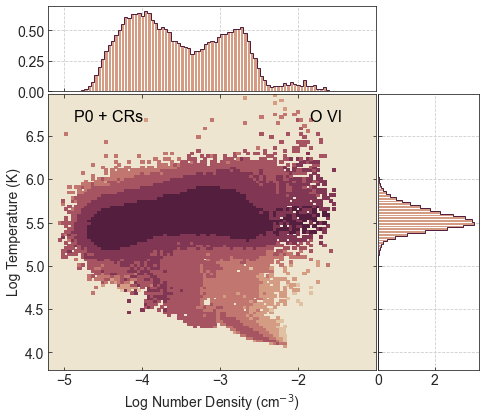

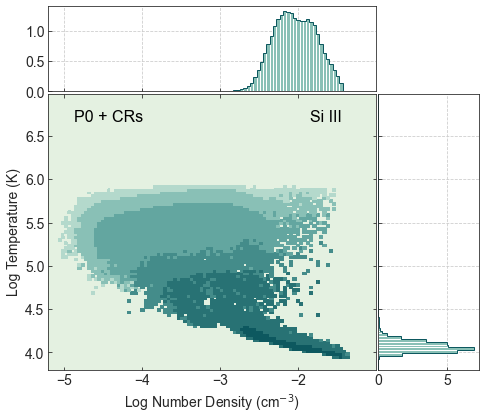

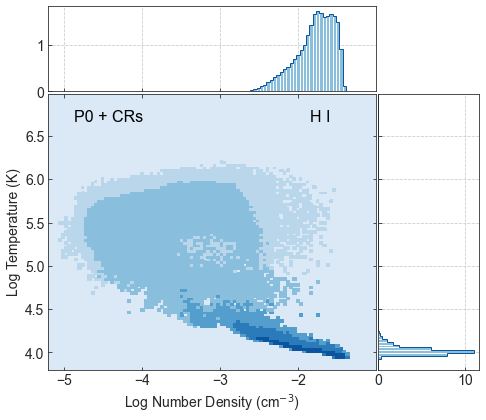

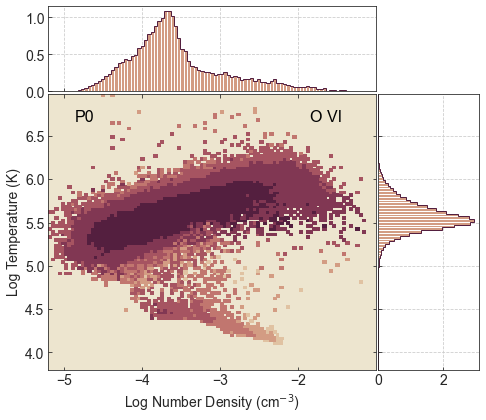

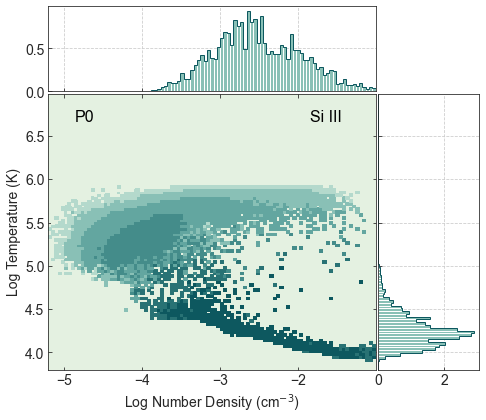

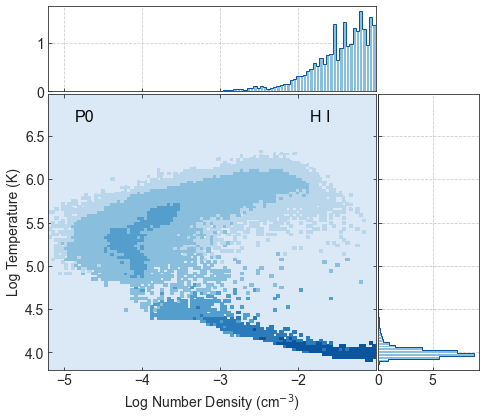

In [91]:
def get_palette(ion):
    if ion == 'O VI':
        palette = palettable.cartocolors.sequential.BrwnYl_7.mpl_colors
    elif ion == 'Si III':
        palette = palettable.cartocolors.sequential.Mint_7.mpl_colors
    elif ion == 'H I':
        #palette = palettable.colorbrewer.sequential.PuBu_9.mpl_colors
        palette = sns.color_palette("Blues")
    #BYW = np.vstack((white, palettable.cartocolors.sequential.BrwnYl_7.mpl_colors))

    return palette

def plot_phase(model, ion = 'O VI'):
    
    ds, gcenter, bv = spg.load_simulation_properties(model)
    trident.add_ion_fields(ds, ions = [ion])  
    
    sp1 = ds.sphere(gcenter, (15, 'kpc'))
    sp2 = ds.sphere(gcenter, (200, 'kpc'))
    sp = sp2 - sp1

    logx_list = np.log10(sp[xfield])
    logy_list = np.log10(sp[yfield])
    
    ion_name = ipd.return_ion_prefix(ion)
    mass_list = sp['%s_mass'%ion_name].in_units('Msun')


    xlims = (-5.2, -1.01)
    ylims = (3.8, 6.99)

    xedges = np.linspace(xlims[0], xlims[1], 100)
    yedges = np.linspace(ylims[0], ylims[1], 100)
    weights = mass_list
    normed = True
    #weights = None

    H, xedges, yedges = np.histogram2d(logx_list, logy_list, bins = (xedges, yedges), weights = weights, normed = normed)
    H = H.T
    X, Y = np.meshgrid(xedges, yedges)


    # definitions for the axes
    left, width = 0.12, 0.65
    bottom, height = 0.11, 0.65
    spacing = 0.005
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.2]
    rect_histy = [left + width + spacing, bottom, 0.2, height]

    fig = plt.figure(figsize=(7, 5.9))
    fs = 14
    ax_scatter = plt.axes(rect_scatter)
    ax_scatter.tick_params(direction='in', top=True, right=True, labelsize = fs)
    ax_histx = plt.axes(rect_histx)
    ax_histx.tick_params(direction='in', labelbottom=False, labelsize = fs)
    ax_histy = plt.axes(rect_histy)
    ax_histy.tick_params(direction='in', labelleft=False, labelsize = fs)

    ax_scatter.set_xlim(xlims[0], xlims[1])
    ax_scatter.set_ylim(ylims[0], ylims[1])
    ax_histx.set_xlim(ax_scatter.get_xlim())
    ax_histy.set_ylim(ax_scatter.get_ylim())


    ax_scatter.set_xlabel('Log Number Density (cm$^{-3}$)', fontsize = fs)
    ax_scatter.set_ylabel('Log Temperature (K)', fontsize = fs)

   # palette = sns.color_palette("Blues")
#    cmap = cmListedColormap(palette)
    palette = get_palette(ion)
    cmap = ListedColormap(palette)
    background = palette[0]

    ax_scatter.pcolormesh(X, Y, H, norm = LogNorm(), cmap = cmap)
    ax_scatter.set_facecolor(background)


    # add ion and model labels
    xtext = 0.8*(xlims[1] - xlims[0]) + xlims[0]
    ytext = 0.9*(ylims[1] - ylims[0]) + ylims[0]
    ax_scatter.text(xtext, ytext, ion, fontsize = fs+2, color = 'black')
    
    xtext = 0.08*(xlims[1] - xlims[0]) + xlims[0]
    if model == 'P0':
        ax_scatter.text(xtext, ytext, model, fontsize = fs+2, color = 'black')
    else:
        ax_scatter.text(xtext, ytext, 'P0 + CRs', fontsize = fs+2, color = 'black')


    
    ax_histx.hist(logx_list, bins=xedges, weights = weights, density = normed, color = palette[2])
    ax_histx.hist(logx_list, bins=xedges, weights = weights, density = normed, 
                  histtype = 'step', color = palette[-1])
    ax_histy.hist(logy_list, bins=yedges, weights = weights, density = normed, 
                  orientation = 'horizontal', color = palette[2])
    ax_histy.hist(logy_list, bins=yedges, weights = weights, density = normed, 
                  orientation = 'horizontal', histtype = 'step', color = palette[-1])


    ion = ion.replace(" ", "")
    plt.savefig('../../plots/phase_%s_%s.png'%(ion, model), dpi = 300)

    
model_list = ['P0_agncr', 'P0']
ion_list = ['O VI', 'Si III', 'H I']

#ion_list = ['H I']

for model in model_list:
    for ion in ion_list:
        plot_phase(model, ion)

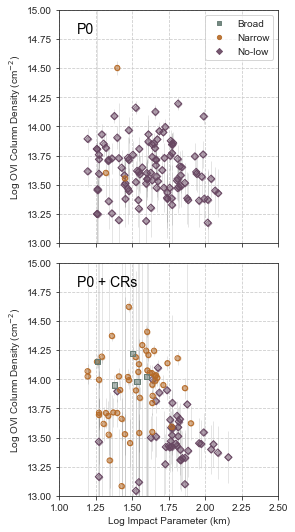

In [17]:
# plotting O VI label plots
def plot_ovi(xfield):
    ion_list, logN_list, logNerr_list, b_list, berr_list, zcen_list, \
                zcen_sd_list, ray_id_list, model_list, vel_list, impact_list, ovi_label_list = pt.load_csv_data()

    if xfield == 'bval':
        x_list = np.log10(b_list)
        xerr_list = np.log10(berr_list)
        xlims = (0.7, 2)
        xlabel = 'Log Doppler b (km/s)'
    elif xfield == 'impact':
        x_list = np.log10(impact_list)
        xerr_list = np.zeros(len(impact_list))
        xlims = (1, 2.5)
        xlabel = 'Log Impact Parameter (km)'

    
    fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (4.2, 7.5), sharex = True, sharey = True)
  #  ax.plot([0.7, 2.7], [13.5, 15.5], color = 'black', linestyle = 'dashed')

    label_list = ['broad', 'narrow', 'nolow']
    legend_list = ['Broad', 'Narrow', 'No-low']
    marker_list = ['s', 'o', 'D']
    zorder_list = [3, 2, 1]
    color_list = [palettable.wesanderson.Moonrise2_4.mpl_colors[0], palettable.wesanderson.Moonrise2_4.mpl_colors[1], 
                  palettable.wesanderson.Darjeeling4_5.mpl_colors[1]]
    for col, model in enumerate(['P0', 'P0agncr']):
        for i, label in enumerate(label_list):
            mask = (ion_list == 'OVI') & (model_list == model) & (ovi_label_list == label)
           # ax.scatter(np.log10(b_list[mask]), logN_list[mask], label = legend_list[i])
            x = x_list[mask]
            xerr = xerr_list[mask]
            y = logN_list[mask]
            yerr = logNerr_list[mask]
            ax[col].errorbar(x, y, xerr=xerr, yerr=yerr, linewidth = 0.5, 
                             color = 'black', linestyle = '', alpha = 0.2, zorder = 0)
            ax[col].scatter(x, y, s = 26, marker = marker_list[i], 
                       edgecolor = color_list[i], color = 'None', zorder= zorder_list[i])
            ax[col].scatter(x, y, s = 23, marker = marker_list[i], 
                       color = color_list[i], zorder= zorder_list[i], alpha = 0.5)
            # dummy for legend
            ax[col].scatter(-1, -1, s = 18, marker = marker_list[i], 
                       color = color_list[i], label = legend_list[i], alpha = 0.9)
                
        ax[col].set_ylabel('Log OVI Column Density (cm$^{-2}$)')
     
    ylims = (13, 15)
    ax[0].set_xlim(xlims)#0.7, 2)
    ax[0].set_ylim(ylims)
    ax[1].set_xlabel(xlabel)

    
    xtext = 0.08*(xlims[1] - xlims[0]) + xlims[0]
    ytext = 0.9*(ylims[1] - ylims[0]) + ylims[0]
    ax[0].text(xtext, ytext, 'P0', fontsize = 14, color = 'black')
    ax[1].text(xtext, ytext, 'P0 + CRs', fontsize = 14, color = 'black')
    
    ax[0].legend()
    fig.tight_layout()
    plt.savefig('../../plots/OVI_%s_col.png'%xfield, dpi = 300)

plot_ovi('impact')

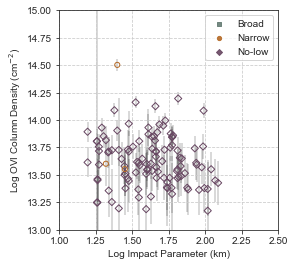

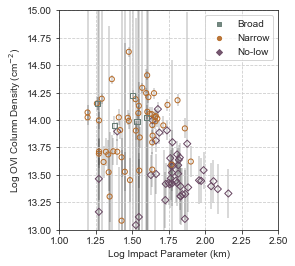

In [5]:
# plotting O VI impact plots
def plot_impact_ovi(model):
    ion_list, logN_list, logNerr_list, b_list, berr_list, zcen_list, \
                zcen_sd_list, ray_id_list, model_list, vel_list, impact_list, ovi_label_list = pt.load_csv_data()

    fig, ax = plt.subplots(figsize = (4.2, 3.8))

    label_list = ['broad', 'narrow', 'nolow']
    legend_list = ['Broad', 'Narrow', 'No-low']
    marker_list = ['s', 'o', 'D']
    zorder_list = [3, 2, 1]
    color_list = [palettable.wesanderson.Moonrise2_4.mpl_colors[0], palettable.wesanderson.Moonrise2_4.mpl_colors[1], 
                  palettable.wesanderson.Darjeeling4_5.mpl_colors[1]]
    for i, label in enumerate(label_list):
        mask = (ion_list == 'OVI') & (model_list == model) & (ovi_label_list == label)
        x = np.log10(impact_list[mask])
        y = logN_list[mask]
        yerr = logNerr_list[mask]
        ax.errorbar(x, y, yerr=yerr, color = 'black', linestyle = '', alpha = 0.2, zorder = 0)
        ax.scatter(x, y, s = 26, marker = marker_list[i], 
                   edgecolor = color_list[i], color = 'None', zorder= zorder_list[i])
        ax.scatter(x, y, s = 26, marker = marker_list[i], 
                   color = color_list[i], color = 'None', zorder= zorder_list[i])
        # dummy for legend
        ax.scatter(-1, -1, s = 18, marker = marker_list[i], 
                   color = color_list[i], label = legend_list[i], alpha = 0.9)
    ax.set_xlim(1, 2.5)
    ax.set_ylim(13.0, 15.0)   
    ax.set_xlabel('Log Impact Parameter (km)')
    ax.set_ylabel('Log OVI Column Density (cm$^{-2}$)')
    ax.legend()
    fig.tight_layout()
    plt.savefig('../../plots/OVI_impact_col_%s.png'%model, dpi = 300)

for model in ['P0', 'P0agncr']:
    plot_impact_ovi(model)

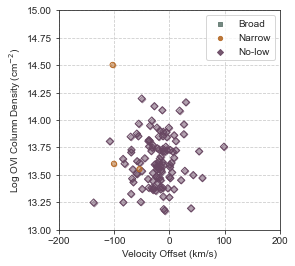

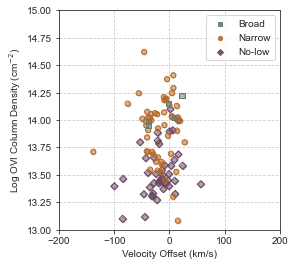

In [3]:
# plotting O VI impact plots
def plot_bval_ovi(model):
    ion_list, logN_list, logNerr_list, b_list, berr_list, zcen_list, \
                zcen_sd_list, ray_id_list, model_list, vel_list, impact_list, ovi_label_list = pt.load_csv_data()

    fig, ax = plt.subplots(figsize = (4.2, 3.8))

    label_list = ['broad', 'narrow', 'nolow']
    legend_list = ['Broad', 'Narrow', 'No-low']
    marker_list = ['s', 'o', 'D']
    zorder_list = [3, 2, 1]
    color_list = [palettable.wesanderson.Moonrise2_4.mpl_colors[0], palettable.wesanderson.Moonrise2_4.mpl_colors[1], 
                  palettable.wesanderson.Darjeeling4_5.mpl_colors[1]]
    for i, label in enumerate(label_list):
        mask = (ion_list == 'OVI') & (model_list == model) & (ovi_label_list == label)
       # ax.scatter(np.log10(b_list[mask]), logN_list[mask], label = legend_list[i])
        ax.scatter(vel_list[mask], logN_list[mask], s = 26, marker = marker_list[i], 
                   edgecolor = color_list[i], color = 'None', zorder= zorder_list[i])
        ax.scatter(vel_list[mask], logN_list[mask], s = 23, marker = marker_list[i], 
                   color = color_list[i], zorder= zorder_list[i], alpha = 0.5)
        # dummy for legend
        ax.scatter(-1, -1, s = 18, marker = marker_list[i], 
                   color = color_list[i], label = legend_list[i], alpha = 0.9)
    ax.set_xlim(-200, 200)
    ax.set_ylim(13.0, 15.0)   
    ax.set_xlabel('Velocity Offset (km/s)')
    ax.set_ylabel('Log OVI Column Density (cm$^{-2}$)')
    ax.legend()
    fig.tight_layout()
    plt.savefig('../../plots/OVI_vel_col_%s.png'%model, dpi = 300)

for model in ['P0', 'P0agncr']:
    plot_bval_ovi(model)